# Renderização de Cenários com Gaussian Splatting

Este guia contempla um guia definitivo para tornar qualquer conjunto de imagens ou video em um ambiente 3D gerado completamente por meio do método de Gaussian Splatting.

A utilização do notebook se dará pela possibilidade do uso de GPU para o processo de treinamento das gaussianas.

Desta forma, o guia é dividido em três etapas que não precisam rodar em ordem.

1. Criação de um dataset personalizado;
2. Treinamento da nuvem gaussiana;
3. Visualização WEB do cenário.

## Criação do Dataset Personalizado

Para começarmos é importante mencionar que essa seção somente é necessária caso deseja-se renderizar um cenário novo, na seção de treinamento será fornecido um dataset exemplo para otimizar o tempo.

Para começarmos é necessário ou um conjunto de imagens de um cenário com o máximo de ângulos possíveis para melhor geração do ambiente, em caso de você já ter este conjunto de imagens você pode prosseguir para a etapa seguinte, desconsiderando a etapa abaixo:

### Gerar dataset a partir de um vídeo

A ideia aqui é realizar a extração dos frames e construir o dataset por meio do vídeo que você gerou.

In [5]:
import cv2
import os
from google.colab import files
from IPython.display import display, Javascript
def clean_output():
  display(Javascript('google.colab.output.clear()'))
print("Por favor, selecione o arquivo de vídeo (.mp4) para fazer o upload.")
try:
    clean_output()
    uploaded = files.upload()
    video_path = next(iter(uploaded))
    print(f"\nArquivo '{video_path}' carregado com sucesso!")
    output_folder = 'myproject'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"Pasta '{output_folder}' criada para salvar os frames.")
    else:
        print(f"Salvando frames na pasta já existente: '{output_folder}'.")
    vid_cap = cv2.VideoCapture(video_path)
    if not vid_cap.isOpened():
        raise IOError(f"Não foi possível abrir o arquivo de vídeo: {video_path}")

    print("\nIniciando a extração dos frames. Isso pode levar alguns minutos...")

    count = 0
    success = True

    while success:
        success, image = vid_cap.read()

        if success:
            frame_filename = os.path.join(output_folder, f"frame_{count:05d}.jpg")
            cv2.imwrite(frame_filename, image)

            count += 1
    vid_cap.release()

    print(f"\nProcesso concluído!")
    print(f"Total de {count} frames extraídos e salvos na pasta '{output_folder}'.")
    print("Você pode encontrar a pasta no painel de arquivos à esquerda.")


except StopIteration:
    print("\nNenhum arquivo foi selecionado. Por favor, execute a célula novamente.")
except Exception as e:
    print(f"\nOcorreu um erro: {e}")

Por favor, selecione o arquivo de vídeo (.mp4) para fazer o upload.


<IPython.core.display.Javascript object>

Saving VID_20250715_043125.mp4 to VID_20250715_043125 (1).mp4

Arquivo 'VID_20250715_043125 (1).mp4' carregado com sucesso!
Pasta 'myproject' criada para salvar os frames.

Iniciando a extração dos frames. Isso pode levar alguns minutos...

Processo concluído!
Total de 553 frames extraídos e salvos na pasta 'myproject'.
Você pode encontrar a pasta no painel de arquivos à esquerda.


In [6]:
import os
import shutil
from google.colab import files

nome_da_pasta = 'myproject'
nome_do_arquivo_zip = 'myproject'

if os.path.isdir(nome_da_pasta):
    print(f"Iniciando a compactação da pasta '{nome_da_pasta}'...")

    shutil.make_archive(nome_do_arquivo_zip, 'zip', nome_da_pasta)

    print(f"✅ Pasta compactada com sucesso! O arquivo '{nome_do_arquivo_zip}.zip' foi criado.")
    print("\nO download iniciará automaticamente em seu navegador.")
    print("Se o download não começar, verifique as permissões de pop-up do seu navegador.")

    files.download(f'{nome_do_arquivo_zip}.zip')

else:
    print(f"ERRO: A pasta '{nome_da_pasta}' não foi encontrada.")
    print("Por favor, certifique-se de que você executou a célula anterior para extrair os frames primeiro.")

Iniciando a compactação da pasta 'myproject'...
✅ Pasta compactada com sucesso! O arquivo 'myproject.zip' foi criado.

O download iniciará automaticamente em seu navegador.
Se o download não começar, verifique as permissões de pop-up do seu navegador.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Com os frames no seu computador extraia o zip e crie dentro da pasta "myproject" uma pasta chamada images, na qual você deve colocar todas as imagens geradas pelo seu video.

Na sequência iremos usar uma outra ferramenta chamada [Colmap](https://colmap.github.io/install.html), na qual vamos usar a [Versão Windows](https://github.com/colmap/colmap/releases) 3.8.

Primeiro passo é abrir o programa e clicar em Automatic Reconstrution
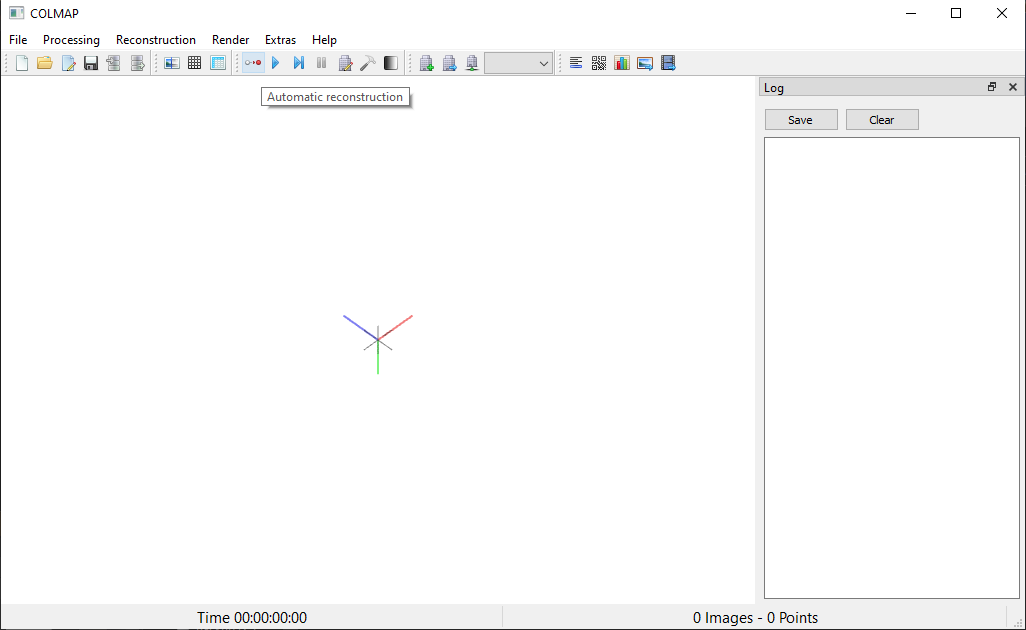

- Selecione 'Workspace folder' como myproject.
- Selecione 'Image folder' como myproject/images.
- Se suas imagens vierem de um video selecione em 'Data type' Video frames.
- Tire a seleção de Dense Model.
- Clique em 'Run'.

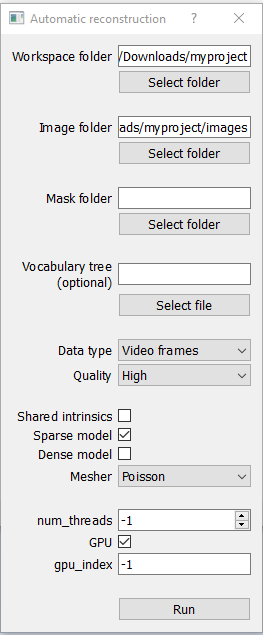

Depois de um tempo teremos a nuvem de pontos 3D do que filmamos/fotografamos

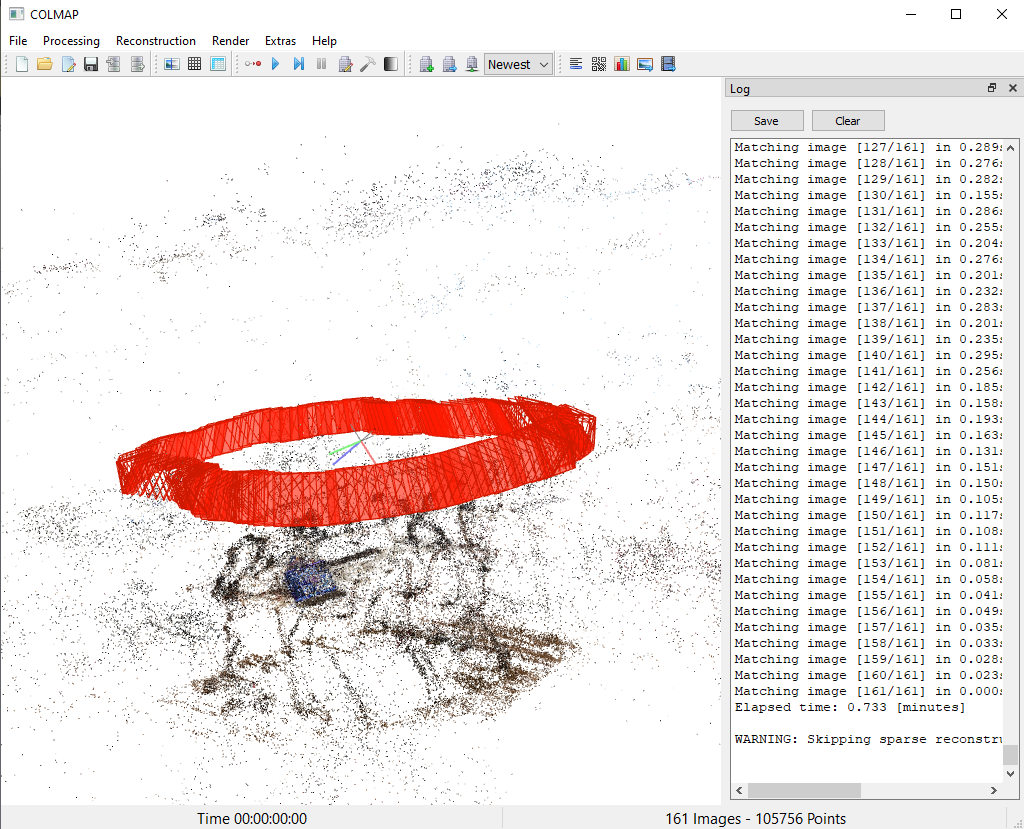

Depois disso, precisamos alterar as câmeras para os tipos que o gaussian splatting consegue ler, que são pinhole ou simple pinhole.

Para fazer isso:
Vá em 'Arquivo' (File) > 'Abrir projeto' (Open project) e selecione o arquivo: myproject/sparse/0/project.ini.
Depois, vá em 'Processamento' (Processing) > 'Gerenciamento de banco de dados' (Database management).
Abra a aba 'Câmeras' (Cameras), você deve ver algo parecido com isto, com pelo menos uma câmera:

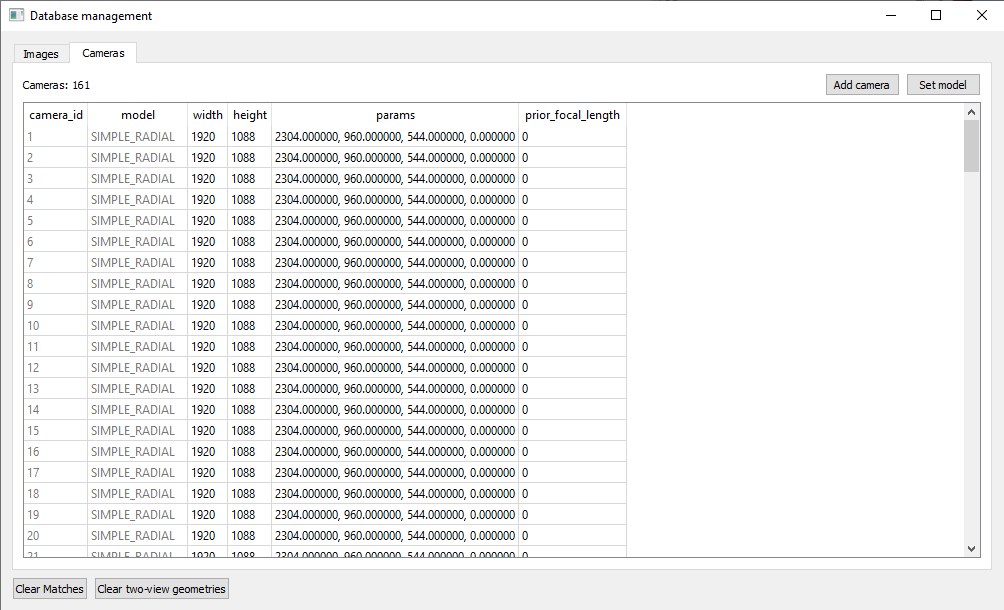

Pressione 'Ctrl + A' para selecionar todas as câmeras, clique em 'Definir modelo' (Set model) e selecione 'Pinhole'.

Depois, você pode fechar a aba de Gerenciamento de banco de dados (Database management).

Por fim, vá em 'Reconstrução' (Reconstruction) > 'Iniciar reconstrução' (Start reconstruction).

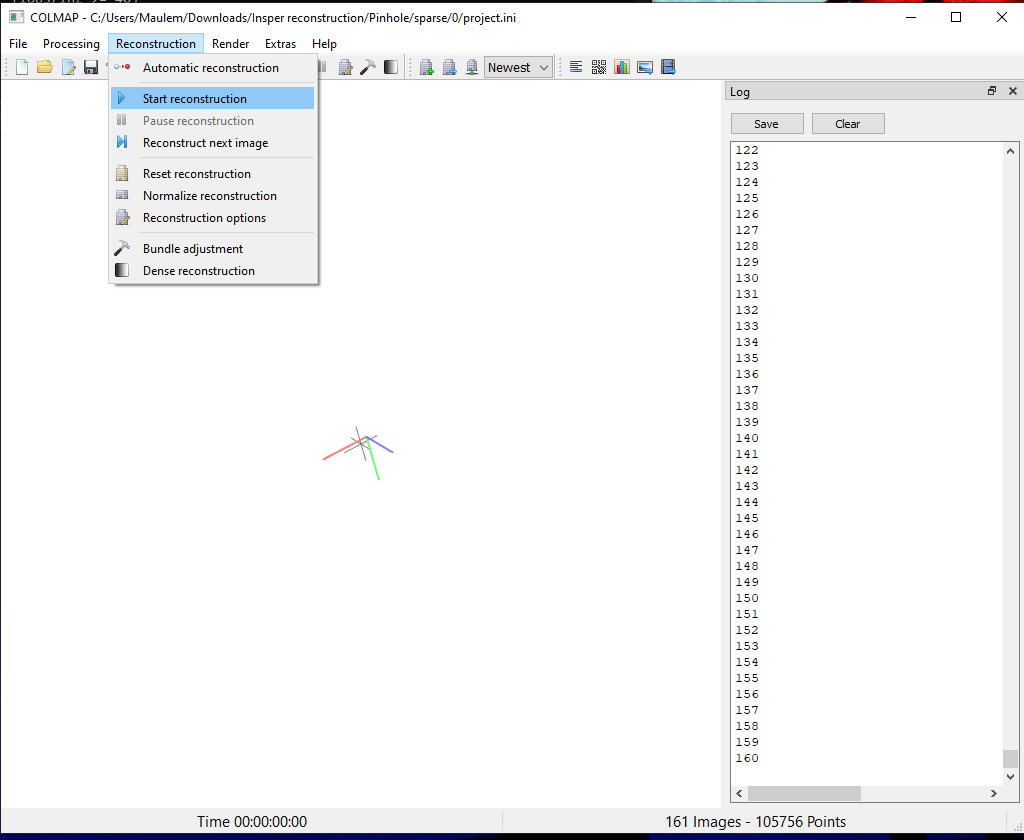

Após reconstruir a cena, vamos exportar os dados para que possamos usá-los no Google Colab.

Clique em 'Arquivo' (File) > 'Exportar modelo' (Export model) e selecione a pasta myproject. Isso salvará 4 arquivos que usaremos mais tarde:

cameras.bin

images.bin

points3D.bin

project.ini

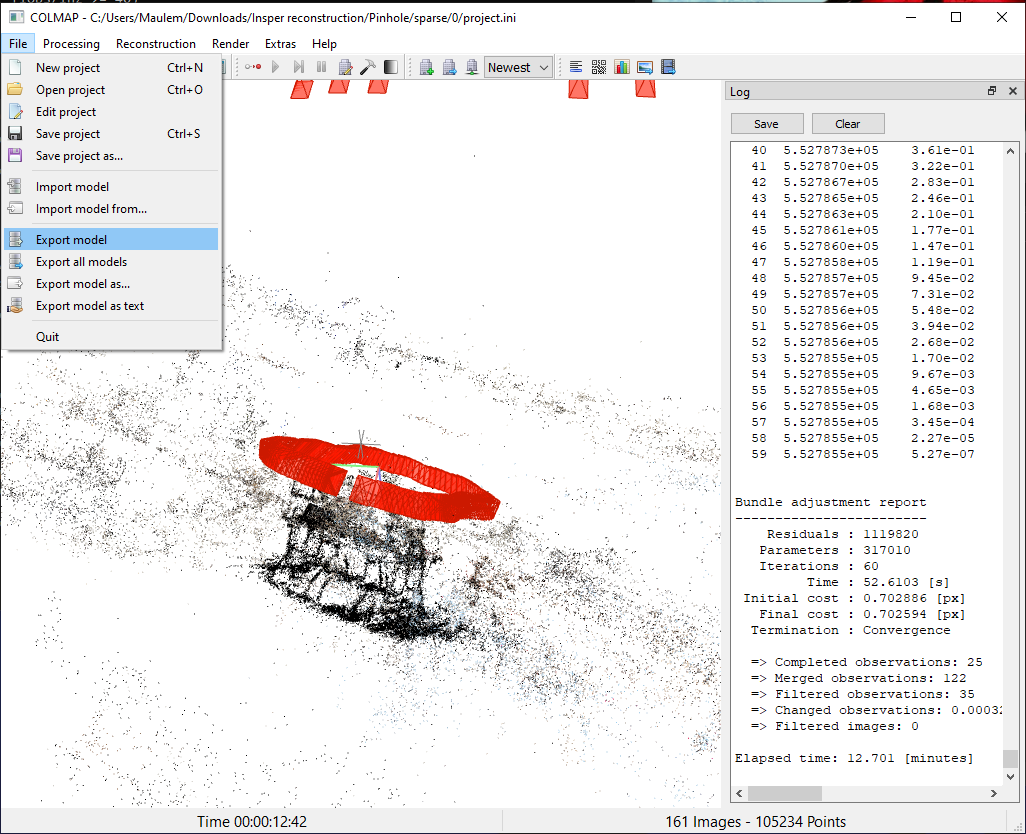

### Treinamento da Nuvem Gaussiana

Aqui nesta etapa iremos trazer para nosso ambiente Colab as dependências necessárias para possibilitar o uso da tecnologia portanto temos alguns passos para tornar o uso possível.

### Downgrade do Python

In [1]:
!wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py37_23.1.0-1-Linux-x86_64.sh
!chmod +x mini.sh
!bash ./mini.sh -b -f -p /usr/local
!conda install -q -y python=3.7
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')
!python --version

--2025-07-15 16:32:39--  https://repo.anaconda.com/miniconda/Miniconda3-py37_23.1.0-1-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.191.158, 104.16.32.241, 2606:4700::6810:20f1, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.191.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90665082 (86M) [application/x-sh]
Saving to: ‘mini.sh’

mini.sh             100%[===================>]  86.46M   121MB/s    in 0.7s    

2025-07-15 16:32:40 (121 MB/s) - ‘mini.sh’ saved [90665082/90665082]

PREFIX=/usr/local
Unpacking payload ...
                                                                                
Installing base environment...





Preparing transaction: - \ | / done
Executing transaction: \ | / - \ | / - \ | / - \ | / - \ | / done
installation finished.
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior when running 

### CUDA 11.8

In [2]:
!wget https://developer.download.nvidia.com/compute/cuda/11.8.0/local_installers/cuda_11.8.0_520.61.05_linux.run
!chmod +x cuda_11.8.0_520.61.05_linux.run
!./cuda_11.8.0_520.61.05_linux.run --silent --toolkit --no-drm --no-man-page
import os
os.environ['PATH'] += ':/usr/local/cuda-11.8/bin'
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda-11.8/lib64:/usr/lib64-nvidia'
!nvcc --version

--2025-07-15 16:33:15--  https://developer.download.nvidia.com/compute/cuda/11.8.0/local_installers/cuda_11.8.0_520.61.05_linux.run
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 23.43.51.10, 23.43.51.15
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|23.43.51.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4336730777 (4.0G) [application/octet-stream]
Saving to: ‘cuda_11.8.0_520.61.05_linux.run’

cuda_11.8.0_520.61. 100%[===================>]   4.04G   242MB/s    in 17s     

2025-07-15 16:33:33 (239 MB/s) - ‘cuda_11.8.0_520.61.05_linux.run’ saved [4336730777/4336730777]

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


### PyTorch com CUDA

In [3]:
!pip uninstall torch torchvision torchaudio -y
!pip install torch==1.12.1+cu116 torchvision==0.13.1+cu116 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 GB 479.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 95.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 49.9 MB/s eta 0:00:00


### Verificando as versões

In [1]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))
!nvidia-smi

True
12.4
Tesla T4
Tue Jul 15 16:40:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------------------

### Trazendo o método de Gaussian Splatting

In [2]:
%cd /content
!git clone --recursive https://github.com/kauaortiz/gaussian-splatting
!pip install -q plyfile

%cd /content/gaussian-splatting
!pip install -q /content/gaussian-splatting/submodules/diff-gaussian-rasterization
!pip install -q /content/gaussian-splatting/submodules/simple-knn

/content
Cloning into 'gaussian-splatting'...
remote: Enumerating objects: 603, done.
remote: Total 603 (delta 0), reused 0 (delta 0), pack-reused 603 (from 1)
Receiving objects: 100% (603/603), 2.09 MiB | 5.65 MiB/s, done.
Resolving deltas: 100% (347/347), done.
Submodule 'SIBR_viewers' (https://gitlab.inria.fr/sibr/sibr_core) registered for path 'SIBR_viewers'
Submodule 'submodules/diff-gaussian-rasterization' (https://github.com/graphdeco-inria/diff-gaussian-rasterization) registered for path 'submodules/diff-gaussian-rasterization'
Submodule 'submodules/simple-knn' (https://gitlab.inria.fr/bkerbl/simple-knn.git) registered for path 'submodules/simple-knn'
Cloning into '/content/gaussian-splatting/SIBR_viewers'...
remote: Enumerating objects: 3293, done.        
remote: Counting objects: 100% (322/322), done.        
remote: Compressing objects: 100% (174/174), done.        
remote: Total 3293 (delta 171), reused 280 (delta 148), pack-reused 2971 (from 1)        
Receiving objects: 

### OPCIONAL: EXTRAÇÃO DE DATASET EXEMPLO E SEU TREINAMENTO

In [6]:
!wget https://huggingface.co/camenduru/gaussian-splatting/resolve/main/tandt_db.zip
!unzip tandt_db.zip

!python train.py -s /content/gaussian-splatting/tandt/train

--2025-07-15 16:50:40--  https://huggingface.co/camenduru/gaussian-splatting/resolve/main/tandt_db.zip
Resolving huggingface.co (huggingface.co)... 18.164.174.55, 18.164.174.118, 18.164.174.17, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.55|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/69/11/6911555bcb5edae447d514169831329398b45a3ed9ae3b00817878bc501559a1/816e62f22a161abbfe841d2a6b10cdf036e297c9fa289b3bfeee9c6ec526d7e1?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27tandt_db.zip%3B+filename%3D%22tandt_db.zip%22%3B&response-content-type=application%2Fzip&Expires=1752601840&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1MjYwMTg0MH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy82OS8xMS82OTExNTU1YmNiNWVkYWU0NDdkNTE0MTY5ODMxMzI5Mzk4YjQ1YTNlZDlhZTNiMDA4MTc4NzhiYzUwMTU1OWExLzgxNmU2MmYyMmExNjFhYmJmZTg0MWQyYTZiMTBjZGYwMzZlMjk3YzlmYTI4OWIzYmZlZWU5YzZlYz

### OPÇÃO DATASET PRÓPRIO:


Primeiro crie os diretórios

In [3]:
%cd /content
!mkdir myproject
!mkdir myproject/images
%cd /content/myproject
!mkdir sparse
!mkdir sparse/0

/content
/content/myproject


Insira

* cameras.bin
* images.bin
* points3D.bin
* project.ini

Em myproject/sparse/0 e todas as imagens em myproject/images

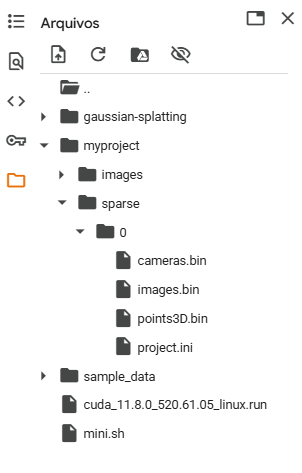

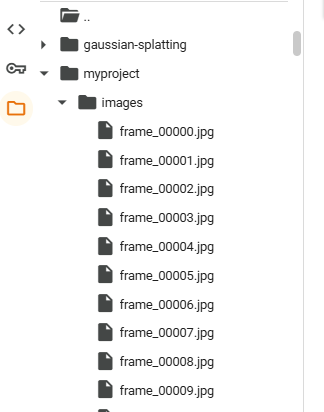

In [8]:
%cd /content/gaussian-splatting
!python train.py -s /content/myproject/

/content/gaussian-splatting
Optimizing 
Output folder: ./output/ca2da27e-8 [15/07 17:00:10]
Tensorboard not available: not logging progress [15/07 17:00:10]
Reading camera 553/553 [15/07 17:00:11]
Converting point3d.bin to .ply, will happen only the first time you open the scene. [15/07 17:00:11]
Loading Training Cameras [15/07 17:00:12]
[ INFO ] Encountered quite large input images (>1.6K pixels width), rescaling to 1.6K.
 If this is not desired, please explicitly specify '--resolution/-r' as 1 [15/07 17:00:12]
Loading Test Cameras [15/07 17:01:17]
Number of points at initialisation :  48151 [15/07 17:01:17]
Training progress:  23% 7000/30000 [13:18<44:26,  8.63it/s, Loss=0.0416923]
[ITER 7000] Evaluating train: L1 0.019046742282807828 PSNR 29.333055114746095 [15/07 17:14:36]

[ITER 7000] Saving Gaussians [15/07 17:14:36]
Training progress: 100% 30000/30000 [54:50<00:00,  9.12it/s, Loss=0.0281350]

[ITER 30000] Evaluating train: L1 0.014527144096791745 PSNR 31.440272903442384 [15/07 1

Cor arquivos pesados, talvez seja necessário salvar a nuvem de pontos diretamente no Drive, para isso monte o drive no ambiente Colab.

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Crie a pasta do Drive e passe o caminho da sua nuvem de pontos e o caminho dos outputs.

In [10]:
!mkdir -p /content/drive/MyDrive/Colab_Outputs/
!cp /content/gaussian-splatting/output/ca2da27e-8/point_cloud/iteration_30000/point_cloud.ply /content/drive/MyDrive/Colab_Outputs/

## Visualização Web

Ao final do treinamento do modelo acima o modelo treinado pode ser localizado em: 'gaussian-splating/output/######/point_cloud/iteration_30000/point_cloud.ply'

Este point_cloud.ply deve ser baixado para sua máquina para que possamos inseri-lo no respectivo [Visualizador Web](https://antimatter15.com/splat/)

### Visualização Web Local

In [ ]:
%cd /content
!git clone https://github.com/camenduru/splat
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb -O /content/cloudflared-linux-amd64.deb
!dpkg -i cloudflared-linux-amd64.deb

import atexit, requests, subprocess, time, re, os
from random import randint
from threading import Timer
from queue import Queue
def cloudflared(port, metrics_port, output_queue):
    atexit.register(lambda p: p.terminate(), subprocess.Popen(['cloudflared', 'tunnel', '--url', f'http://127.0.0.1:{port}', '--metrics', f'127.0.0.1:{metrics_port}'], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT))
    attempts, tunnel_url = 0, None
    while attempts < 10 and not tunnel_url:
        attempts += 1
        time.sleep(3)
        try:
            tunnel_url = re.search("(?P<url>https?:\/\/[^\s]+.trycloudflare.com)", requests.get(f'http://127.0.0.1:{metrics_port}/metrics').text).group("url")
        except:
            pass
    if not tunnel_url:
        raise Exception("Can't connect to Cloudflare Edge")
    output_queue.put(tunnel_url)
output_queue, metrics_port = Queue(), randint(8100, 9000)
thread = Timer(2, cloudflared, args=(7860, metrics_port, output_queue))
thread.start()
thread.join()
tunnel_url = output_queue.get()
os.environ['webui_url'] = tunnel_url
%cd /content/splat
print(tunnel_url)

!python -m http.server 7860